In [ ]:
pip install xgboost

In [98]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import *
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import xgboost as xgb
import math
import seaborn as sns
from sklearn.model_selection import cross_val_score
import random
from os import write

# 1. Old Notebook Stuff

In [99]:
PLOT_FONT_SIZE = 10    #font size for axis of plots

#define helper function for confusion matrix

def displayConfusionMatrix(confusionMatrix):
    """Confusion matrix plot"""

    confusionMatrix = np.transpose(confusionMatrix)

    ## calculate class level precision and recall from confusion matrix
    precisionLow = round((confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[0][1]))*100, 1)
    precisionHigh = round((confusionMatrix[1][1] / (confusionMatrix[1][0] + confusionMatrix[1][1]))*100, 1)
    recallLow = round((confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[1][0]))*100, 1)
    recallHigh = round((confusionMatrix[1][1] / (confusionMatrix[0][1] + confusionMatrix[1][1]))*100, 1)

    ## show heatmap
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues,vmin=0, vmax=100)

    ## axis labeling
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["","Class No Visit \n Recall=" + str(recallLow), "Class Visit \n Recall=" + str(recallHigh), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["","Class No Visit \n Precision=" + str(precisionLow), "Class Visit \n Precision=" + str(precisionHigh), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)

    ## add text in heatmap boxes
    addText(xticks, xticks, confusionMatrix)

def addText(xticks, yticks, results):
    """Add text in the plot"""
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, results[i][j], ha="center", va="center", color="white", size=PLOT_FONT_SIZE) ### size here is the size of text inside a single box in the heatmap

def getFeaturesFromList(inputList, textIndex):
    """Takes as input a list and the index for the text and extract all text"""
    featuresFromList = [removeNans(item[textIndex:]) for item in inputList]
    return featuresFromList

def getLabelsFromList(inputList, labelIndex):
    """Takes as input a list and the index for the label and extract all labels"""
    labels = [0 if item[labelIndex] == "Exited" else 1 for item in inputList]
    return labels

def isnan(object):
    """Checks if a value is null"""
    return object != object

def removeNans(inputList):
    """Remove null values from the list"""
    inputList = [item if isnan(item) == False else 0 for item in inputList]
    return inputList

In [ ]:
#define XGBoost parameter settings
#depth=6
#estimators=1000
#lr=0.01

# fit the unweighted model
#clf = XGBClassifier(objective="binary:logistic", max_depth=depth, n_estimators=estimators, learning_rate=lr, n_jobs=16)
#clf.fit(trainData[:,[0, 4, 5, 7, 10, 11, 13, 16, 17, 19, 20, 22, 24, 26, 27]], trainLabels)
#predictions = clf.predict(testData[:,[0, 4, 5, 7, 10, 11, 13, 16, 17, 19, 20, 22, 24, 26, 27]])

#auc = roc_auc_score(testLabels, predictions)



#generate confusion matrices for the different models' training fit
#non-weighted model
#confusionMatrix = None
#predictions = clf.predict(trainData)
#confusionMatrix = confusion_matrix(trainLabels, predictions)

## confusion matrix
#plt.rcParams['figure.figsize'] = [3, 3] ## plot size
#displayConfusionMatrix(confusionMatrix)
#plt.title("Non-Weighted Model", fontsize=PLOT_FONT_SIZE)
#plt.show()



#generate confusion matrices for the different models' training fit
#non-weighted model
#confusionMatrix = None
#predictions = clf.predict(testData)
#confusionMatrix = confusion_matrix(testLabels, predictions)

## confusion matrix
#plt.rcParams['figure.figsize'] = [3, 3] ## plot size
#displayConfusionMatrix(confusionMatrix)
#plt.title("Non-Weighted Model", fontsize=PLOT_FONT_SIZE)
#plt.show()



# 2. Load Data

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
#get dataset
delimiter = ","

trainInput = pd.DataFrame(pd.read_csv("/content/drive/My Drive/ga_assign/Phishing_TrainSample.csv",sep=delimiter))
testInput = pd.DataFrame(pd.read_csv("/content/drive/My Drive/ga_assign/Phishing_TestSample.csv",sep=delimiter))

## extract data from data frames
dataColumns = list(trainInput.columns)
trainData = getFeaturesFromList(trainInput.values.tolist(), 1)
testData = getFeaturesFromList(testInput.values.tolist(), 1)

## extract labels
trainLabels = getLabelsFromList(trainInput.values.tolist(),0)
testLabels = getLabelsFromList(testInput.values.tolist(),0)

#convert to NP arrays
trainData = np.array(trainData)
testData = np.array(testData)

print('Label: ',trainLabels[0], ' Text: ', trainData[0])
print("Total number of rows", len(trainData))

Label:  1  Text:  [ 0.          0.          0.          0.          1.          1.
  2.          2.          9.16666667  9.          1.          1.
  6.66666667 10.          8.          3.          5.          2.75
  8.75        7.          8.5         5.          5.          2.
  1.          4.          8.          0.        ]
Total number of rows 54384


# 2.5 Hyperparameter Searching/Tuning Attempts

Random stuff, don't have to run for GA

In [ ]:
# Select features (same as before)
X = trainData
y = trainLabels

# Convert to DMatrix (required for xgb.cv)
dtrain = xgb.DMatrix(X, label=y)

# Learning rates to test
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]

# Track CV results
cv_results = {}

# Loop over each learning rate
for lr in learning_rates:
    params = {
        'objective': 'binary:logistic',
        'learning_rate': lr,
        #'max_depth': 6,
        'eval_metric': 'auc',
        'nthread': 16
    }

    cv = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=1500,
        nfold=5,
        stratified=True,
        metrics='auc',
        seed=1600,
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Store mean logloss per iteration
    cv_results[lr] = cv['test-auc-mean']

# Plot
plt.figure(figsize=(10, 6))
for lr, losses in cv_results.items():
    plt.plot(losses, label=f'lr={lr}')

plt.xlabel('Iteration')
plt.ylabel('Mean CV Log Loss')
plt.title('Learning Rate vs. CV Log Loss Over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
clf1 = XGBClassifier(objective="binary:logistic", n_estimators=170, learning_rate=.1, n_jobs=16)
clf1.fit(trainData, trainLabels)
predictions1 = clf1.predict(testData)

auc1 = roc_auc_score(testLabels, predictions1)




clf2 = XGBClassifier(objective="binary:logistic", n_estimators=180, learning_rate=.1, n_jobs=16)
clf2.fit(trainData, trainLabels)
predictions2 = clf2.predict(testData)

auc2 = roc_auc_score(testLabels, predictions2)




clf3 = XGBClassifier(objective="binary:logistic", n_estimators=375, learning_rate=.07, n_jobs=16, max_depth = 6)
clf3.fit(trainData, trainLabels)
predictions3 = clf3.predict(testData)

auc3 = roc_auc_score(testLabels, predictions3)





print(auc1, auc2, auc3)


0.8048774509803922 0.8071813725490197 0.803578431372549


In [ ]:
# Predefined values
learning_rate = 0.05
n_estimators = 250

# Parameter grid
max_depths = [3,5,7,9]
min_child_weights = [1, 3, 5, 7]

# To store AUC scores
results = np.zeros((len(max_depths), len(min_child_weights)))

# Loop through parameter grid
for i, depth in enumerate(max_depths):
    for j, child_weight in enumerate(min_child_weights):
        model = XGBClassifier(
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=depth,
            min_child_weight=child_weight,
            objective='binary:logistic',
            n_jobs=16,
            eval_metric='auc'
        )

        model.fit(trainData, trainLabels)
        predictions = model.predict(testData)
        auc = roc_auc_score(testLabels, predictions)

        results[i, j] = auc
        print(f"depth={depth}, min_child_weight={child_weight} → AUC={auc:.4f}")


depth=3, min_child_weight=1 → AUC=0.7458
depth=3, min_child_weight=3 → AUC=0.7433
depth=3, min_child_weight=5 → AUC=0.7430
depth=3, min_child_weight=7 → AUC=0.7548
depth=5, min_child_weight=1 → AUC=0.7937
depth=5, min_child_weight=3 → AUC=0.7981
depth=5, min_child_weight=5 → AUC=0.7931
depth=5, min_child_weight=7 → AUC=0.7951
depth=7, min_child_weight=1 → AUC=0.8074
depth=7, min_child_weight=3 → AUC=0.8019
depth=7, min_child_weight=5 → AUC=0.8097
depth=7, min_child_weight=7 → AUC=0.7994
depth=9, min_child_weight=1 → AUC=0.7912
depth=9, min_child_weight=3 → AUC=0.7941
depth=9, min_child_weight=5 → AUC=0.7954
depth=9, min_child_weight=7 → AUC=0.8011


In [ ]:
#5, 260, 0.1, 9, 1, 0.9, 1

features = [1, 3, 4, 7, 8, 9, 10, 14, 16, 18, 22, 25, 27]
depth = 5
estimators = 260
lr = 0.1
child_weight = 9
gamma = 1
subsamp = .9
colsamp = 1





clf = XGBClassifier(
    objective="binary:logistic",
    max_depth=depth,
    n_estimators=estimators,
    learning_rate=lr,
    min_child_weight=child_weight,
    gamma=gamma,
    subsample=subsamp,
    colsample_bytree=colsamp,
    n_jobs=16
)
clf.fit(trainData[:,[1, 3, 4, 7, 8, 9, 10, 14, 16, 18, 22, 25, 27]], trainLabels)
predictions = clf.predict(testData[:,[1, 3, 4, 7, 8, 9, 10, 14, 16, 18, 22, 25, 27]])

roc_auc_score(testLabels, predictions)


np.float64(0.8009313725490197)

# 3. GA Functions

## Creating Bitstrings

In [102]:
# search space
depth_list = [2,3,4,5,6,7,8,9,10,11,12,13,14]
eta_list = [.15,.12,.1,.09,.08,.07,.06,.05,.04,.03,.02,.01,.009,.008,.007,.005]

# estimator list by eta, seemed to be better than just listing them all
estimator_list1 = [25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500]
estimator_list05 = [75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550]
estimator_list01 = [500,525,550,575,600,625,650,675,700,725,750,775,800,825,850,875,900,950,1000,1050]
estimator_list005 = [700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1550,1600,1650]

# estimator list if not using dynamic
#estimator_list = [25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600,625,650,675,700,725,750,775,800,825,850,875,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1550,1600,1650]

child_weight_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
gamma_list = [0,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1,2,3,4,5]
subsample_list = [.3,.4,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1]
colsample_list = [.3,.4,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1]





# function to find how many bits are needed to encode a list for a specific parameter
def bit_finder(input):
  """
  input: bitstring that you want to map

  returns number of bits needed to map parameter to a bitstring

  """
  return math.ceil(math.log2(len(input)))



# NEED TO ADD MORE BELOW IF NEW HYPERPARAMETERS ADDED
# length of parameter strings
num_features = trainData.shape[1]
num_depth = bit_finder(depth_list)
num_estimators = bit_finder(estimator_list01)
num_eta = bit_finder(eta_list)

num_child_weight = bit_finder(child_weight_list)
num_gamma = bit_finder(gamma_list)
num_subsample = bit_finder(subsample_list)
num_colsample = bit_finder(colsample_list)

bit_length = num_features + num_depth + num_estimators + num_eta + num_child_weight + num_gamma + num_subsample + num_colsample





# function extract the parameter from the encoded bitstring for a specific parameter
def extract_ind(string, num_bits, orig_list):

  """
  string: bitstring of a given hyperparameter
  num_bits: number of bits needed to map the hyperparameter
  orig_list: search space for the hyperparameter

  returns the parameter value from the bitstring
  """

  # if bitstring of parameter maps 1:1 to search space, easy map
  if 2**num_bits <= len(orig_list):
    total = 0
    for i in range(num_bits):
      hold = int(string[i])*(2**i)
      total += hold
  # if not, have to assign a few options to more than one bit combination
  else:
    total = 0
    for i in range(num_bits):
      hold = int(string[i])*(2**i)
      total += hold
    total = total
    total = math.floor(len(orig_list)/(2**num_bits)*total)


  # return parameter
  value = orig_list[total]

  return value






### NEED TO MODIFY BELOW IF NEW HYPERPARAMETERS ADDED
# decode bitstring to parameters
def decode(bitstring):

    """
    bitstring: complete bitstring for model

    returns all parameters for the model, using extract_ind for each hyperparameter
    """


    # create and order bitstrings for each hyperparameter into one big bigstring
    feature_bits = bitstring[:num_features]
    depth_bits = bitstring[num_features:num_features+num_depth]
    estimators_bits = bitstring[num_features+num_depth:num_features+num_depth+num_estimators]
    eta_bits = bitstring[num_features+num_depth+num_estimators:num_features+num_depth+num_estimators+num_eta]
    child_weight_bits = bitstring[num_features+num_depth+num_estimators+num_eta:num_features+num_depth+num_estimators+num_eta+num_child_weight]
    gamma_bits = bitstring[num_features+num_depth+num_estimators+num_eta+num_child_weight:num_features+num_depth+num_estimators+num_eta+num_child_weight+num_gamma]
    subsample_bits = bitstring[num_features+num_depth+num_estimators+num_eta+num_child_weight+num_gamma:num_features+num_depth+num_estimators+num_eta+num_child_weight+num_gamma+num_subsample]
    colsample_bits = bitstring[num_features+num_depth+num_estimators+num_eta+num_child_weight+num_gamma+num_subsample:num_features+num_depth+num_estimators+num_eta+num_child_weight+num_gamma+num_subsample+num_colsample]

    # extract the index using the function above for each parameter (features are different)
    sel_feat_ind = [i for i, bit in enumerate(feature_bits) if bit == '1']
    sel_depth_ind = extract_ind(depth_bits, num_depth, depth_list)
    sel_eta_ind = extract_ind(eta_bits, num_eta, eta_list)
    sel_child_weight_ind = extract_ind(child_weight_bits, num_child_weight, child_weight_list)
    sel_gamma_ind = extract_ind(gamma_bits, num_gamma, gamma_list)
    sel_subsample_ind = extract_ind(subsample_bits, num_subsample, subsample_list)
    sel_colsample_ind = extract_ind(colsample_bits, num_colsample, colsample_list)

    # select estimators by eta
    if sel_eta_ind >= .075:
      sel_est_ind = extract_ind(estimators_bits, num_estimators, estimator_list1)
    elif sel_eta_ind >= .025:
      sel_est_ind = extract_ind(estimators_bits, num_estimators, estimator_list05)
    elif sel_eta_ind >= .0075:
      sel_est_ind = extract_ind(estimators_bits, num_estimators, estimator_list01)
    elif sel_eta_ind >= .005:
      sel_est_ind = extract_ind(estimators_bits, num_estimators, estimator_list005)




    # if we do not have dynamic estimators
    #sel_est_ind = extract_ind(estimators_bits, num_estimators, estimator_list01)



    return sel_feat_ind, sel_depth_ind, sel_est_ind, sel_eta_ind, sel_child_weight_ind, sel_gamma_ind, sel_subsample_ind, sel_colsample_ind

Creating Functions for Inside GA

In [103]:
# evaluate an XGBoost function based on a specific bitstring's parameters
def evaluate(bitstring, trainData, trainLabels, testData, testLabels, feature_cutdown = True):

    """
    bitstring: entire bitstring for the model
    train/test Data/Labels: training/testing Data/Labels
    feature_cutdown: True means we want to cut down features in the model based on the bitstring map, False means we want to ignore feature bitstring and run model on all features

    returns AUC score for the model based on the bitstring of hyperparameters
    """


    features, depth, estimators, lr, child_weight, gamma, subsamp, colsamp = decode(bitstring)

    # if no features are selected, return 0 for AUC
    if not features:
        return 0

    # train XGBoost with parameters
    clf = XGBClassifier(
        objective="binary:logistic",
        max_depth=depth,
        n_estimators=estimators,
        learning_rate=lr,
        min_child_weight=child_weight,
        gamma=gamma,
        subsample=subsamp,
        colsample_bytree=colsamp,
        n_jobs=16
    )

    # predict and return AUC

    # if we want to include features in GA, use the bitstring to select
    if feature_cutdown:
      clf.fit(trainData[:, features], trainLabels)
      predictions = clf.predict_proba(testData[:, features])[:,1]
    # if we don't, just use all features and ignore bitstring
    else:
      clf.fit(trainData, trainLabels)
      predictions = clf.predict_proba(testData)[:,1]

    return roc_auc_score(testLabels, predictions)


# intiialize size of population
def init_population(size):

    """
    size: population size (number of bitstrings)

    returns a population of bitstrings
    """

    # generate random bitstrings for the population, bits are generated randomly
    return ["".join(random.choice("01") for _ in range(bit_length)) for _ in range(size)]


# for random selection and tournament-style competition inside GA
def select(pop_score, k):

    """
    pop_score: tuple with bitstring in first column and associated AUC in second
    k: amount of bitstrings to compare AUCs

    returns the selected bitstring with the best AUC of the two random
    """

    # select k amount of bits to compare AUCs, take the one with the better AUC
    selected = random.choices(pop_score, k=k)
    return max(selected, key=lambda x: x[1])[0]


# Roulette wheel selection based on fitness-proportional probability
def roulette_select(pop_score):

    """
    pop_score: tuple with bitstring in first column and associated AUC in second

    returns the selected random bitstring based on the fitness-proportional probability
    """

    # sum of all population fitness scores
    total_fitness = sum(score for _, score in pop_score)
    # weighted probability for each bitstring based on AUC
    probs = [score / total_fitness for _, score in pop_score]
    # randomly choose one based on the weighted probs
    selected_index = random.choices(range(len(pop_score)), weights=probs, k=1)[0]
    return pop_score[selected_index][0]


# for crossover after selection
def crossover(p1, p2):

    """
    p1: first parent bitstring from selection
    p2: second parent bitstring from selection

    returns two new bitstrings based on crossover
    """


    # select random point along bitstring and crossover
    point = random.randint(1, bit_length - 1)
    return p1[:point] + p2[point:], p2[:point] + p1[point:]


# for mutation after crossover
def mutation(bitstring, rate):

    """
    bitstring: complete hyperparameter bitstring
    rate: rate of mutation

    returns a mutated bitstring
    """

    # iterate across all bits of a bitstring, mutating at the specified rate
    return "".join(bit if random.random() > rate else "1" if bit == "0" else "0" for bit in bitstring)


# elitism decay based on generation
def get_elitism(gen, base, rate, min_val):

    """
    gen: what generation is currently being run
    base: starting elitism carryover
    rate: linear rate of decay of carryover
    min_val: lowest point to allow elitism carryover to get to

    returns the amount of elitism carryover for the generation
    """

    # decay elitism by a set rate until it reaches the minimum number
    return max(min_val, int(base * (1 - gen * rate)))




Creating GA Main Function

In [104]:
# if you want to continue previously ran GA, read in latest gen here
#read_in = pd.read_csv('/content/drive/My Drive/ga_assign/im_stupid_contin.csv').iloc[:,1].tolist()

# the GA itself
def genetic_algorithm(trainData, trainLabels, testData, testLabels, pop_size, generations, select_type, mutation_rate, elitism_carryover, elitism_decay, elitism_min, feature_cutdown, added_random, try_name):


    """
    train/test Data/Labels: training/testing Data/Labels
    pop_size: size of population
    generations: number of generations
    select_type: 'tournament' for tournament selection, 'roulette' for roulette selection
    mutation_rate: rate of mutation
    elitism_carryover: starting point for elitism carryover, this amount of best AUC bitstrings carried over to next gen
    eltism_decay: linear rate of decay of elitism carryover
    elitism_min: lowest point to allow elitism carryover to get to
    feature_cutdown: True means we want to cut down features in the model based on the bitstring map, False means we want to ignore feature bitstring and run model on all features
    added_random: amount of random bitstrings to add to each new population, add for more diversity
    try_name: name for try to be put in written out csv name
    """


    # initialize pop
    population = init_population(pop_size)

    # initialize pop if reading one in
    #population = read_in


    # for each generation
    for gen in range(generations):

        # change elitism based on decay
        elitism_carryover = get_elitism(gen, elitism_carryover, elitism_decay, elitism_min)

        # compute scores and bind to corresponding bitstrings
        scores = [evaluate(ind, trainData, trainLabels, testData, testLabels) for ind in population]
        pop_score = list(zip(population, scores))

        ### PATH COMMENTED OUT FOR SUBMISSION ###
        # write scores to df
        scores_df = sorted(pop_score, key=lambda x: x[1], reverse=True)
        scores_df = pd.DataFrame(scores_df)
        #scores_df.to_csv(f"/content/drive/My Drive/ga_assign/{try_name}_gen_{gen}.csv")


        # selection, crossover, and mutation that leads to new pop; keep elitism and added random diversity in mind
        if select_type == "tournament":
            new_population = []
            for _ in range((len(pop_score) - elitism_carryover - added_random) // 2):
                p1 = select(pop_score,k=2)
                p2 = select(pop_score,k=2)
                c1, c2 = crossover(p1, p2)
                c1, c2 = mutation(c1, mutation_rate), mutation(c2, mutation_rate)
                new_population.extend([c1, c2])
        if select_type == "roulette":
            new_population = []
            for _ in range((len(pop_score) - elitism_carryover - added_random) // 2):
                p1 = roulette_select(pop_score)
                p2 = roulette_select(pop_score)
                c1, c2 = crossover(p1, p2)
                c1, c2 = mutation(c1, mutation_rate), mutation(c2, mutation_rate)
                new_population.extend([c1, c2])





        # add best performing bitstrings if elitism is present
        if elitism_carryover > 0:
            best_scores = sorted(pop_score, key=lambda x: x[1], reverse=True)[:elitism_carryover]
            new_population.extend([ind for ind, _ in best_scores])

        # add random bitstrings if added random is present
        if added_random > 0:
            random_adds = init_population(added_random)
            new_population.extend(random_adds)

        # make new pop the current pop, print best score
        population = new_population
        best_score = max(scores)
        print(f"Generation {gen+1}: Best AUC = {best_score}")

    # in last generation, calculate the scores and print the df in order
    final_scores = [evaluate(ind, trainData, trainLabels, testData, testLabels, feature_cutdown=feature_cutdown) for ind in population]
    final_sorted = sorted(pop_score, key=lambda x: x[1], reverse=True)

    # return final results df
    return final_sorted


Run GA

In [ ]:

# run GA (below is set-up for final run)
try2 = genetic_algorithm(trainData, trainLabels, testData, testLabels, pop_size = 100, generations = 100, select_type="tournament", mutation_rate = .02, elitism_carryover = 6, feature_cutdown = True, elitism_decay=0, elitism_min=2, added_random = 0, try_name = "im_stupid_contin2")

### PATH COMMENTED OUT FOR SUBMISSION
# write try1 (which is a tuple right now) to a csv file in my drive
try2_df = pd.DataFrame(try2)
#try2_df.to_csv('/content/drive/My Drive/ga_assign/im_stupid_contin2.csv')




# introduce more randomness each gen?

Generation 1: Best AUC = 0.8917254901960785
Generation 2: Best AUC = 0.8917254901960785
Generation 3: Best AUC = 0.8917254901960785
Generation 4: Best AUC = 0.8917254901960785
Generation 5: Best AUC = 0.8917254901960785
Generation 6: Best AUC = 0.8917254901960785
Generation 7: Best AUC = 0.8917254901960785
Generation 8: Best AUC = 0.8917254901960785
Generation 9: Best AUC = 0.8917254901960785
Generation 10: Best AUC = 0.8917254901960785
Generation 11: Best AUC = 0.8917254901960785
Generation 12: Best AUC = 0.8917254901960785
Generation 13: Best AUC = 0.8917254901960785
Generation 14: Best AUC = 0.8917254901960785
Generation 15: Best AUC = 0.8917254901960785
Generation 16: Best AUC = 0.8917254901960785
Generation 17: Best AUC = 0.8917254901960785
Generation 18: Best AUC = 0.8917254901960785
Generation 19: Best AUC = 0.8917254901960785
Generation 20: Best AUC = 0.8917254901960785
Generation 21: Best AUC = 0.8917254901960785
Generation 22: Best AUC = 0.8917254901960785
Generation 23: Best

# 4. Plots

The run 'i'm stupid' (what I ran after realizing predict() bug) try was the best. I only ran for 50 initially but read back in two other times for a total of 150 generations. Read in and plot.

In [110]:
# compute the top performing AUC for each generation


top_rows = []


for i in range(50):
    file_path = f'/content/drive/My Drive/ga_assign/im_stupid_gen_{i}.csv'
    current_doc = pd.read_csv(file_path)

    sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

    top_row = sorted_doc.iloc[0].copy()
    top_row['generation'] = i

    top_rows.append(top_row)


file_path = f'/content/drive/My Drive/ga_assign/im_stupid.csv'
current_doc = pd.read_csv(file_path)

sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

top_row = sorted_doc.iloc[0].copy()
top_row['generation'] = 50

top_rows.append(top_row)



for i in range(50):
    file_path = f'/content/drive/My Drive/ga_assign/im_stupid_contin_gen_{i}.csv'
    current_doc = pd.read_csv(file_path)

    sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

    top_row = sorted_doc.iloc[0].copy()
    top_row['generation'] = i+50

    top_rows.append(top_row)


file_path = f'/content/drive/My Drive/ga_assign/im_stupid_contin.csv'
current_doc = pd.read_csv(file_path)

sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

top_row = sorted_doc.iloc[0].copy()
top_row['generation'] = 100

top_rows.append(top_row)






for i in range(50):
    file_path = f'/content/drive/My Drive/ga_assign/im_stupid_contin2_gen_{i}.csv'
    current_doc = pd.read_csv(file_path)

    sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

    top_row = sorted_doc.iloc[0].copy()
    top_row['generation'] = i+100

    top_rows.append(top_row)


file_path = f'/content/drive/My Drive/ga_assign/im_stupid_contin2.csv'
current_doc = pd.read_csv(file_path)

sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

top_row = sorted_doc.iloc[0].copy()
top_row['generation'] = 150

top_rows.append(top_row)





# read/write these back in if using different directory

#write_df = pd.DataFrame(top_rows)
#write_df.to_csv('/content/drive/My Drive/ga_assign/final_solution_topauc.csv')

#top_rows = pd.read_csv('/content/drive/My Drive/ga_assign/final_solution_topauc.csv')

In [109]:
# compute the average of the top 12 AUCs for each generation

avg_rows = []


for i in range(50):
    file_path = f'/content/drive/My Drive/ga_assign/im_stupid_gen_{i}.csv'
    current_doc = pd.read_csv(file_path)

    sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

    avg_row = sorted_doc.iloc[:12].mean(numeric_only=True)

    avg_row['generation'] = i

    avg_rows.append(avg_row)

file_path = f'/content/drive/My Drive/ga_assign/im_stupid.csv'
current_doc = pd.read_csv(file_path)

sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

avg_row = sorted_doc.iloc[:12].mean(numeric_only=True)
avg_row['generation'] = 50

avg_rows.append(avg_row)



for i in range(50):
    file_path = f'/content/drive/My Drive/ga_assign/im_stupid_contin_gen_{i}.csv'
    current_doc = pd.read_csv(file_path)

    sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

    avg_row = sorted_doc.iloc[:12].mean(numeric_only=True)

    avg_row['generation'] = i + 50

    avg_rows.append(avg_row)

file_path = f'/content/drive/My Drive/ga_assign/im_stupid_contin.csv'
current_doc = pd.read_csv(file_path)

sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

avg_row = sorted_doc.iloc[:12].mean(numeric_only=True)
avg_row['generation'] = 100

avg_rows.append(avg_row)




for i in range(50):
    file_path = f'/content/drive/My Drive/ga_assign/im_stupid_contin2_gen_{i}.csv'
    current_doc = pd.read_csv(file_path)

    sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

    avg_row = sorted_doc.iloc[:12].mean(numeric_only=True)

    avg_row['generation'] = i + 100

    avg_rows.append(avg_row)

file_path = f'/content/drive/My Drive/ga_assign/im_stupid_contin2.csv'
current_doc = pd.read_csv(file_path)

sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

avg_row = sorted_doc.iloc[:12].mean(numeric_only=True)
avg_row['generation'] = 150

avg_rows.append(avg_row)




# read/write these back in if using different directory

#write_df = pd.DataFrame(avg_rows)
#write_df.to_csv('/content/drive/My Drive/ga_assign/final_solution_top12.csv')

#avg_rows_pd = pd.read_csv('/content/drive/My Drive/ga_assign/final_solution_top12.csv')

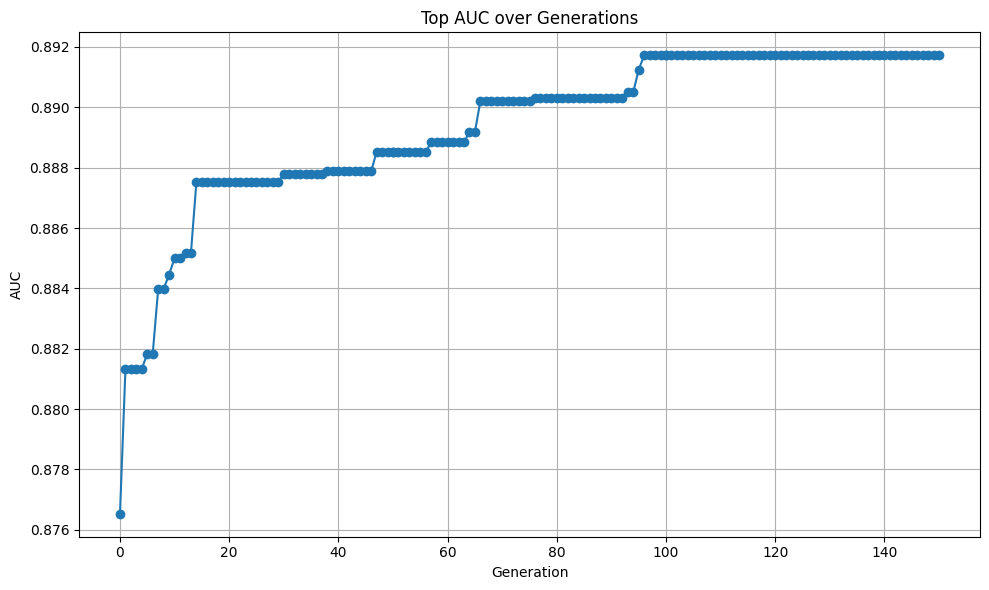

In [107]:
# plot the top AUC by gen

top_df = pd.DataFrame(top_rows)

metric_col = top_df.columns[2]

top_df = top_df.sort_values(by='generation')

plt.figure(figsize=(10, 6))
plt.plot(top_df['generation'], top_df[metric_col], marker='o')
plt.title(f'Top AUC over Generations')
plt.xlabel('Generation')
plt.ylabel('AUC')
plt.grid(True)
plt.tight_layout()
plt.show()

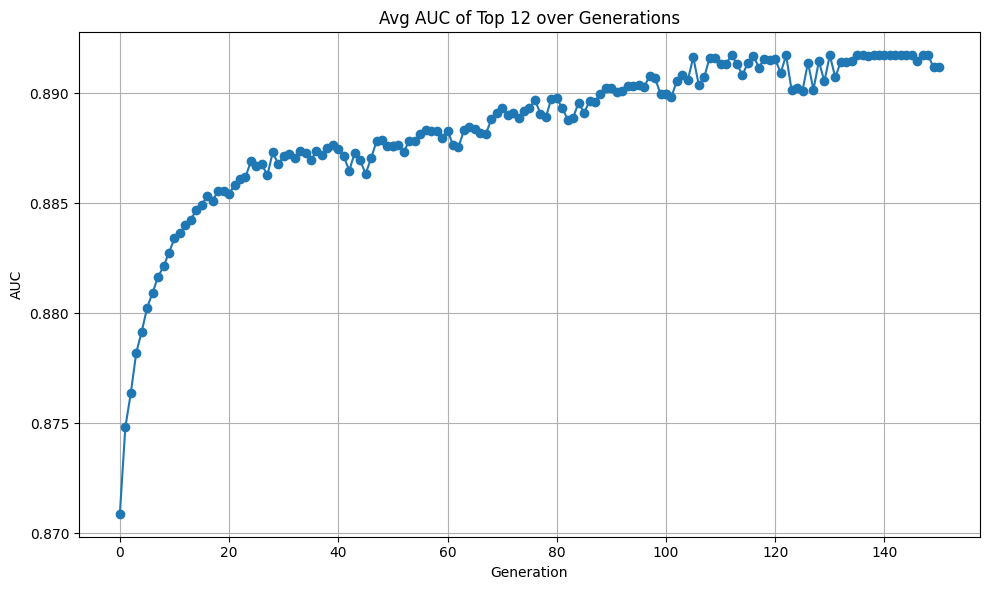

In [108]:
# plot the top 12 AUC average by gen

avg_df = pd.DataFrame(avg_rows)

metric_col = avg_df.columns[1]

avg_df = avg_df.sort_values(by='generation')

plt.figure(figsize=(10, 6))
plt.plot(avg_df['generation'], avg_df[metric_col], marker='o')
plt.title(f'Avg AUC of Top 12 over Generations')
plt.xlabel('Generation')
plt.ylabel('AUC')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Final Solution

In [111]:
# 100th generation

file_path = f'/content/drive/My Drive/ga_assign/im_stupid_contin.csv'
current_doc = pd.read_csv(file_path)

sorted_doc = current_doc.sort_values(by=current_doc.columns[2], ascending=False)

sorted_doc.head(20)

,Unnamed: 0,0,1
0,0,1111110100110001010101110001011100100100110110...,0.891725
1,1,1111110100110001010101110001011100100100110110...,0.891725
2,2,1111110100110001010101110001011100100100110110...,0.891725
3,3,1111110100110001010101110001011100100100110110...,0.891725
4,4,1111110100110001010101110001011100000100110110...,0.891250
5,5,1111110100110001010101110001011100100100110110...,0.890613
6,6,1111110100110001010101110001111100100100110110...,0.890324
7,7,1111110100110001010101110001011100100100110010...,0.889272
8,8,1111110100110001010101110001101100100100110110...,0.889047
9,9,1110110100110001010101110001111101100100110110...,0.887578


In [112]:
# decode best bitstring
decode('1111110100110001010101110001011100100100110110111100110100')

([0, 1, 2, 3, 4, 5, 7, 10, 11, 15, 17, 19, 21, 22, 23, 27],
 13,
 125,
 0.03,
 11,
 4,
 0.85,
 0.4)

In [113]:
# use evaluate() to double check best bitstring (should be 89.17)
evaluate('1111110100110001010101110001011100100100110110111100110100', trainData,trainLabels, testData,testLabels)

np.float64(0.8917254901960785)

In [114]:
# triple check just using xgboost itself

features = [0, 1, 2, 3, 4, 5, 7, 10, 11, 15, 17, 19, 21, 22, 23, 27]

clf = XGBClassifier(
    objective="binary:logistic",
    max_depth=13,
    n_estimators=125,
    learning_rate=.03,
    min_child_weight=11,
    gamma=4,
    subsample=.85,
    colsample_bytree=.4,
    n_jobs=16
)



clf.fit(trainData[:, features], trainLabels)
predictions = clf.predict_proba(testData[:, features])[:,1]


roc_auc_score(testLabels, predictions)

np.float64(0.8917254901960785)